In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os


In [106]:

dataset_name = 'df_drop_appCat'
df = pd.read_csv(f'tables/preprocessed/{dataset_name}.csv')
df.head()

,id_num,mood,screen,activity,activity_max,circumplex.valence,circumplex.valence_min,circumplex.valence_max,circumplex.arousal,circumplex.arousal_min,circumplex.arousal_max,day,next_day,next_day_mood,date
0,1,6.20,17978.907000,3.083152,0.798387,0.2,0.0,1.0,0.2,-1.0,1.0,2014-03-21,2014-03-22 00:00:00,6.40,2014-03-21
1,1,6.40,6142.161000,3.790084,0.508475,0.5,-1.0,1.0,0.6,-1.0,1.0,2014-03-22,2014-03-23 00:00:00,6.80,2014-03-22
2,1,6.80,6773.832001,2.141117,0.313559,0.8,0.0,1.0,0.2,-1.0,1.0,2014-03-23,2014-03-24 00:00:00,6.00,2014-03-23
3,1,6.00,15047.351001,1.895065,0.361345,0.0,-1.0,1.0,0.8,-1.0,2.0,2014-03-24,2014-03-25 00:00:00,6.75,2014-03-24
4,1,6.75,21475.354999,2.360979,0.594828,0.5,0.0,1.0,0.5,-1.0,1.0,2014-03-25,2014-03-26 00:00:00,6.60,2014-03-25


In [107]:
# select everything except day, date, next_day
X = df.drop(columns=['day', 'date', 'next_day', "next_day_mood"])
y = df['next_day_mood']

# get dummies for id_num
X = pd.get_dummies(X, columns=['id_num'])

                         R2       MAE       MSE      RMSE         dataset
Random Forest      0.310106  0.442311  0.382462  0.618435  df_drop_appCat
XGBoost Regressor  0.288553  0.463493  0.394411  0.628022  df_drop_appCat
Ridge Regression   0.274771  0.456406  0.402052  0.634076  df_drop_appCat
Linear Regression  0.274739  0.456447  0.402069   0.63409  df_drop_appCat
Lasso Regression  -0.012301  0.535948  0.561198  0.749132  df_drop_appCat
Elastic Net       -0.012301  0.535948  0.561198  0.749132  df_drop_appCat
Decision Tree       -0.2645  0.609092  0.701012  0.837264  df_drop_appCat


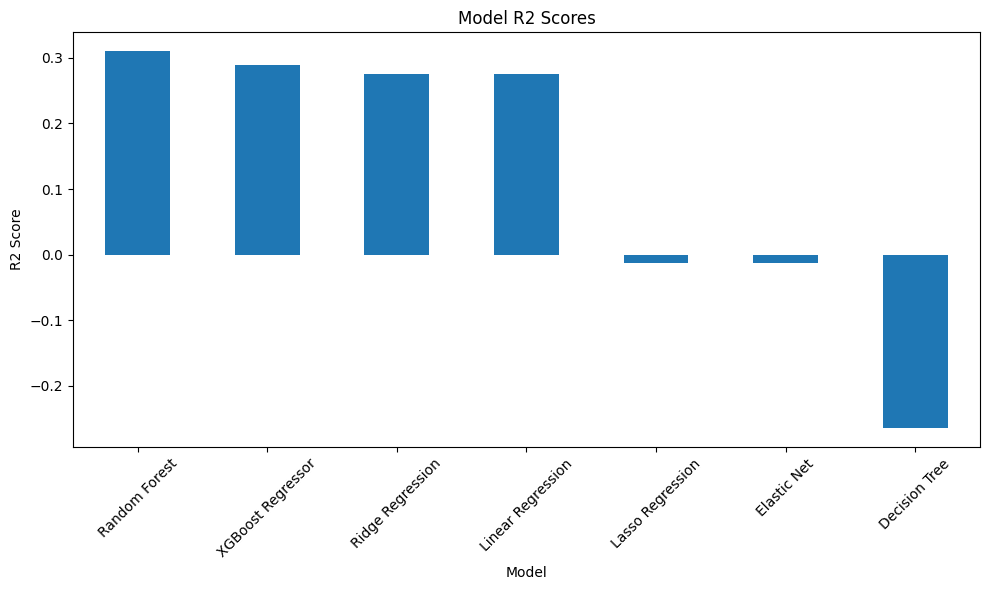

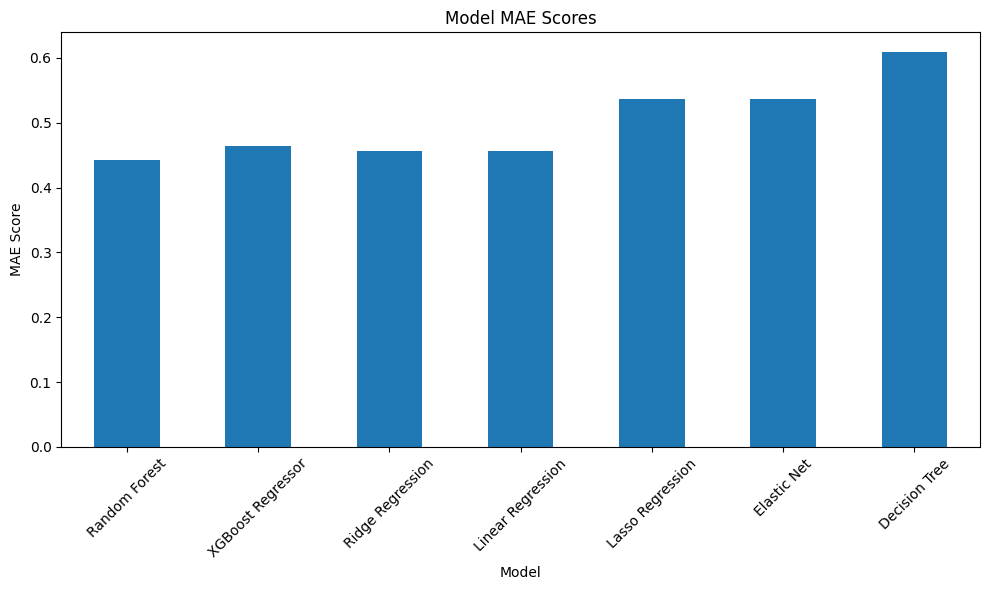

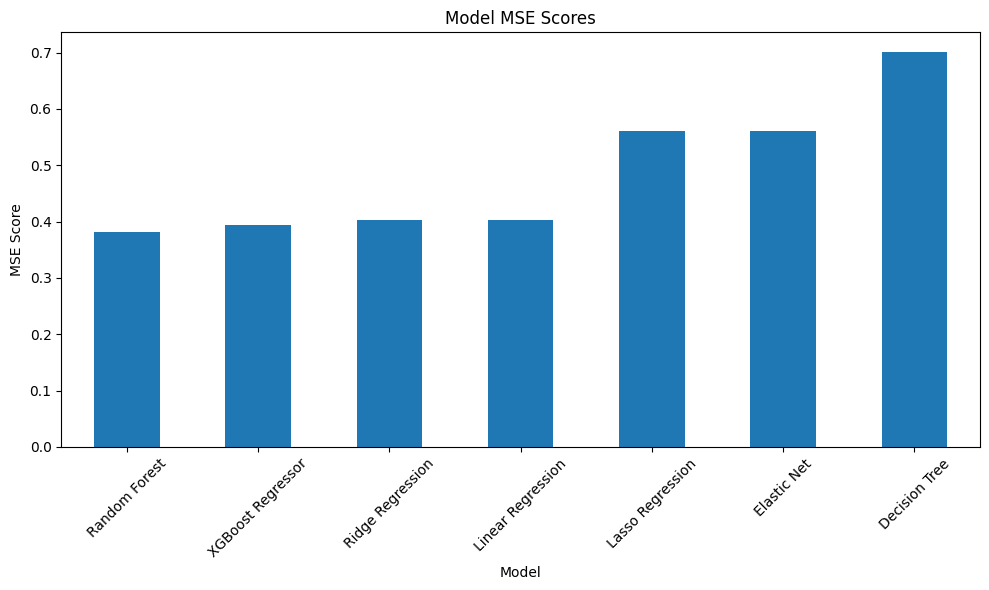

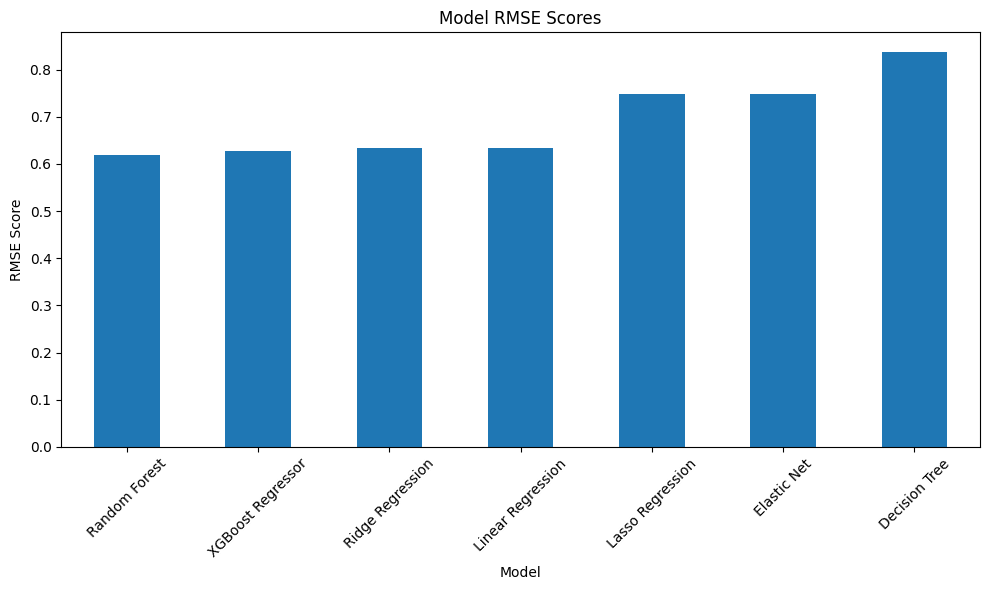

In [108]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# define models
models = {
    'Linear Regression': LinearRegression(), 
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(), 
    'XGBoost Regressor': XGBRegressor()
}
# fit models and evaluate
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    results[name] = {
        'R2': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        "dataset": dataset_name
    }
# print results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='R2', ascending=False)
print(results_df)
# plot results
plt.figure(figsize=(10, 6))
results_df['R2'].plot(kind='bar')
plt.title('Model R2 Scores')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_r2_scores.png')
plt.show()
# plot results
plt.figure(figsize=(10, 6))
results_df['MAE'].plot(kind='bar')
plt.title('Model MAE Scores')
plt.xlabel('Model')
plt.ylabel('MAE Score')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_mae_scores.png')
plt.show()

# plot results
plt.figure(figsize=(10, 6))
results_df['MSE'].plot(kind='bar')
plt.title('Model MSE Scores')
plt.xlabel('Model')
plt.ylabel('MSE Score')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_mse_scores.png')
plt.show()

# plot results
plt.figure(figsize=(10, 6))
results_df['RMSE'].plot(kind='bar')
plt.title('Model RMSE Scores')
plt.xlabel('Model')
plt.ylabel('RMSE Score')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('tables/preprocessed/model_rmse_scores.png')
plt.show()

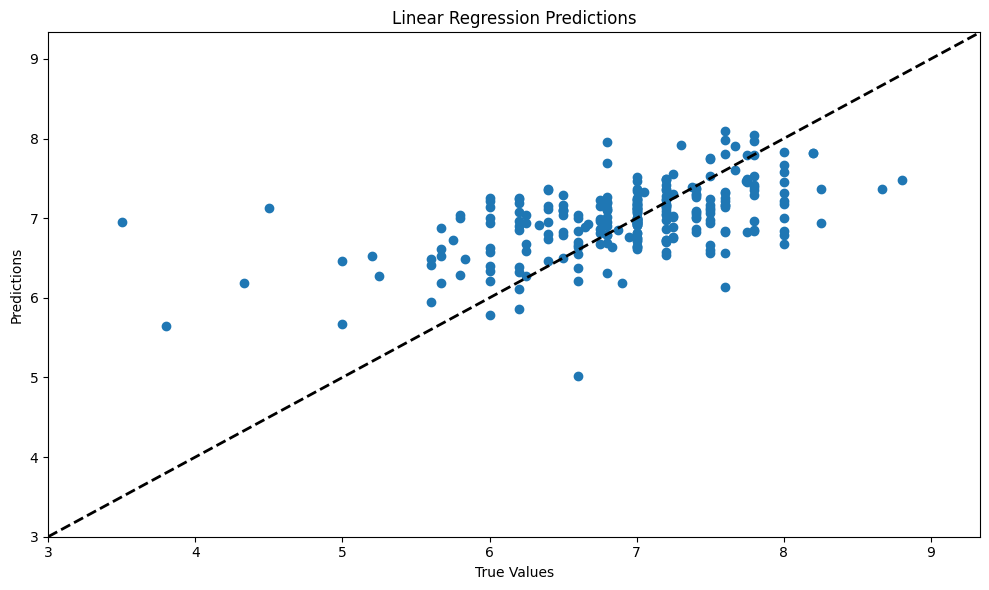

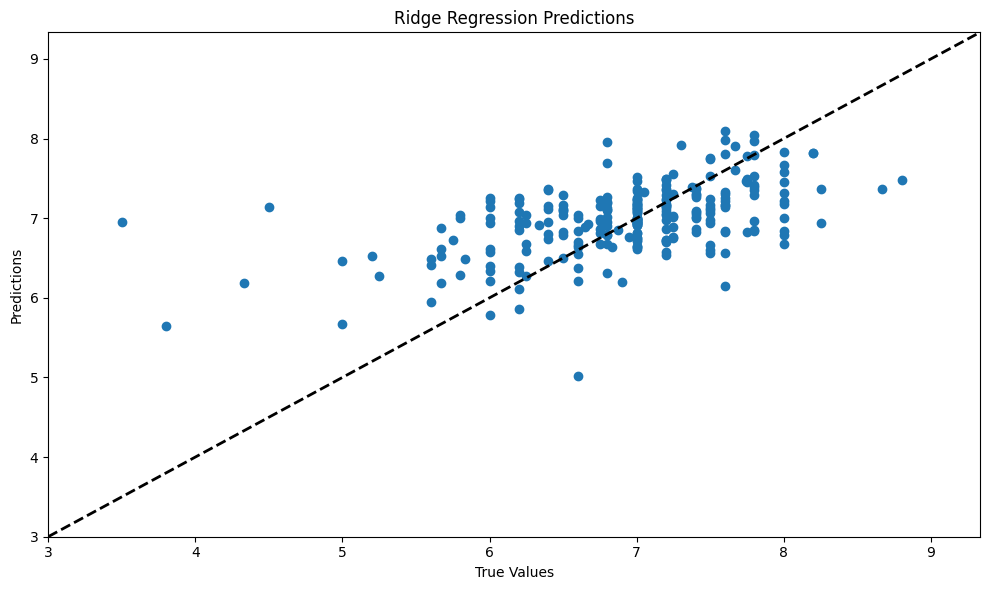

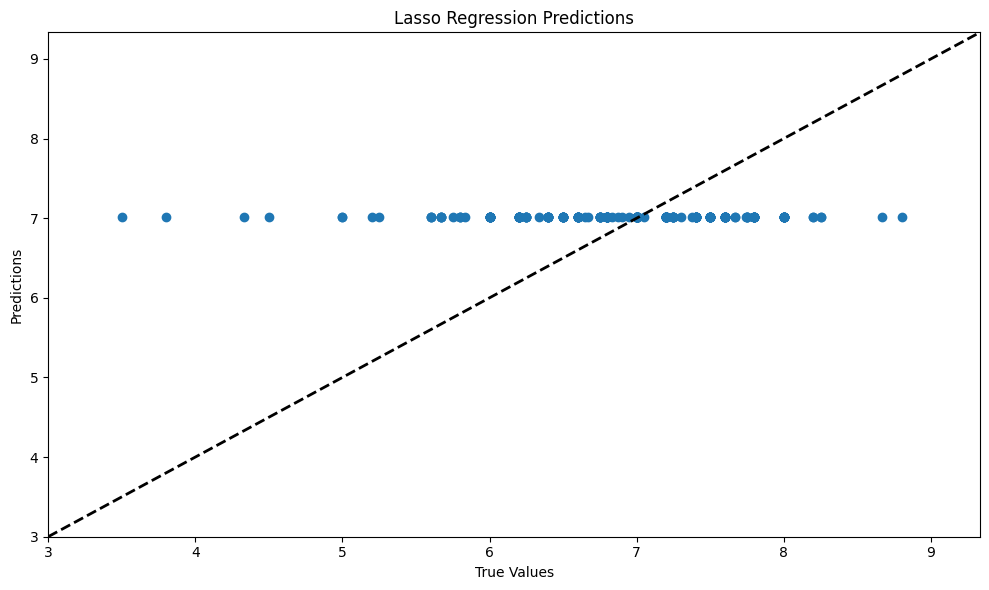

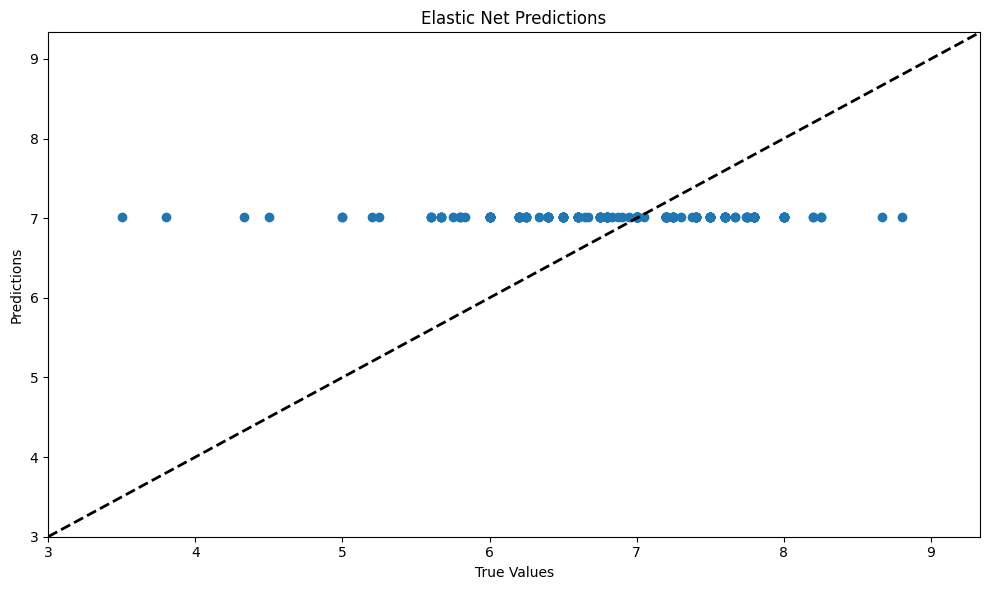

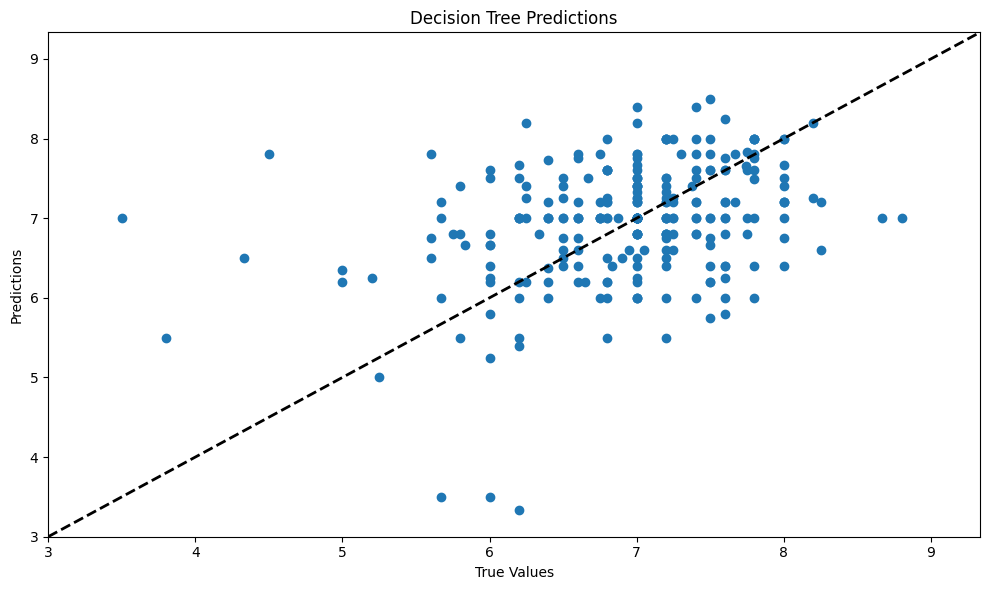

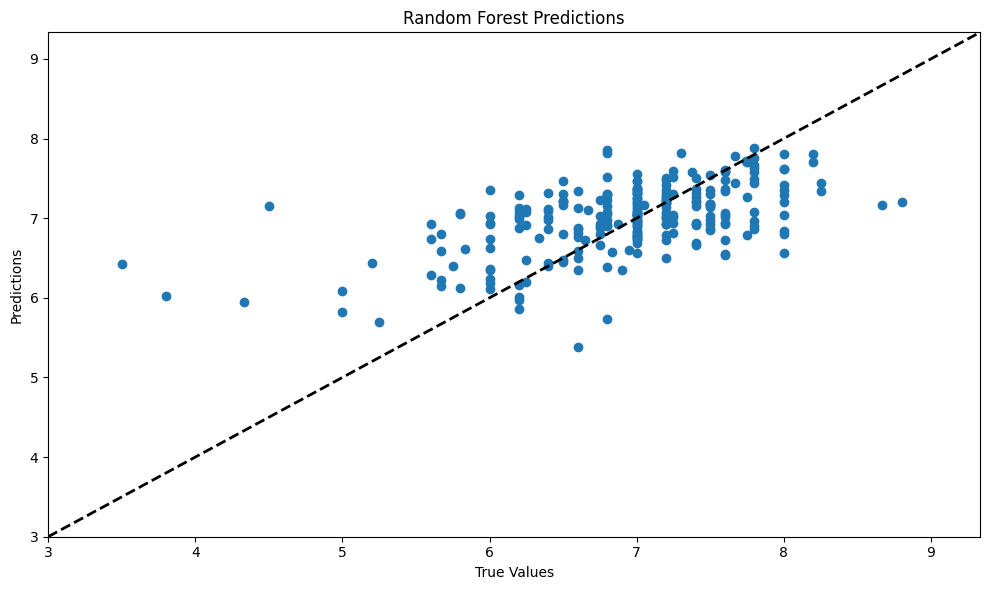

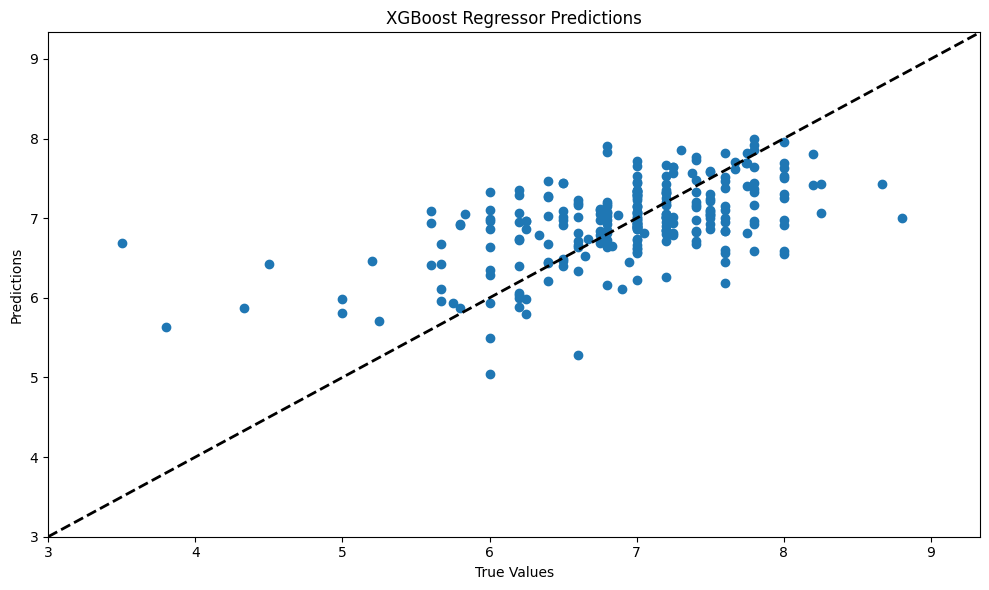

In [109]:
# plot predictions
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred)
    plt.title(f'{name} Predictions')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlim(y.min(), y.max())
    plt.ylim(y.min(), y.max())
    plt.tight_layout()
    # plt.savefig(f'tables/preprocessed/{name}_predictions.png')
    plt.show()
    

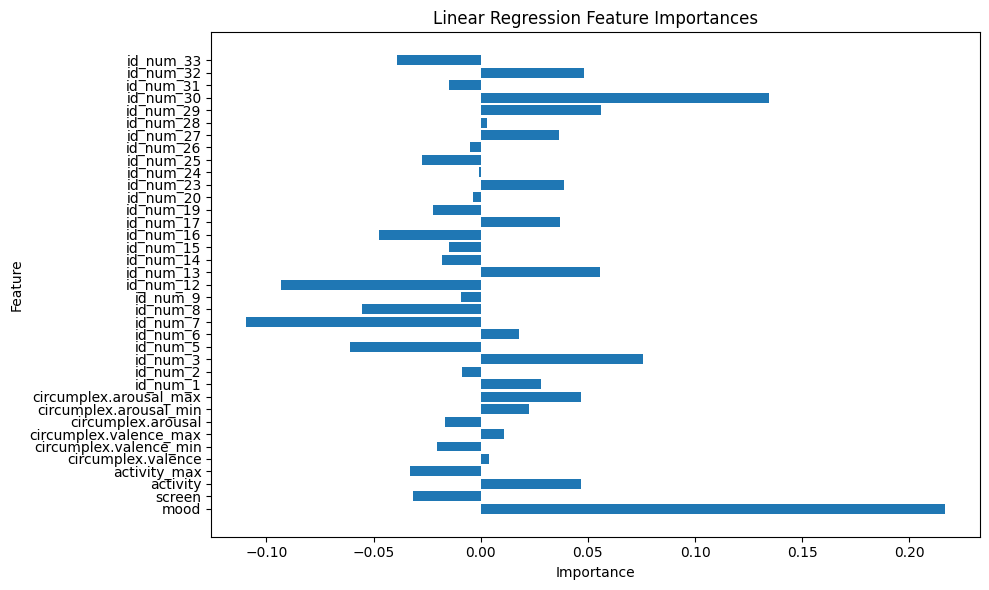

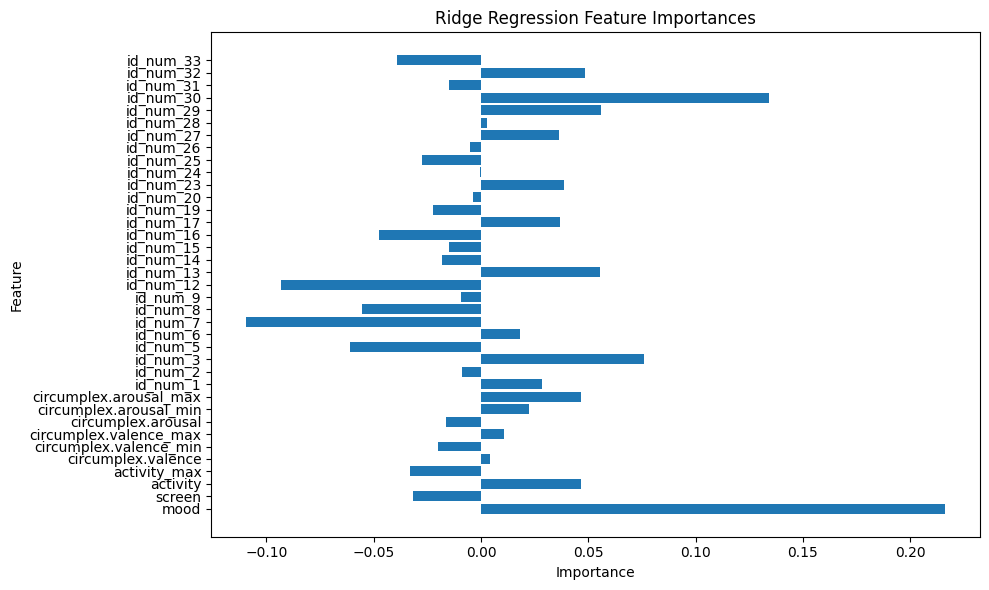

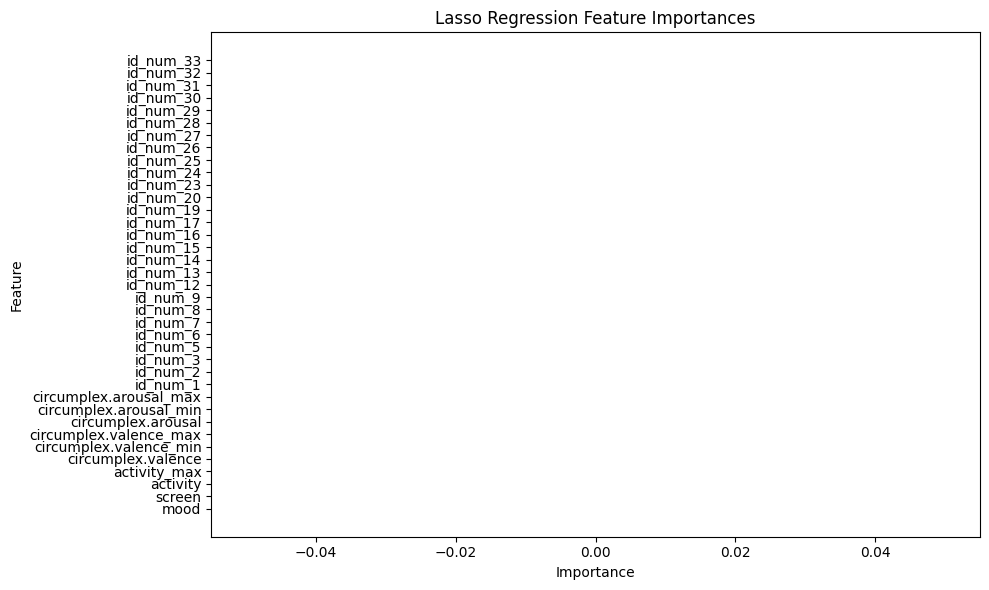

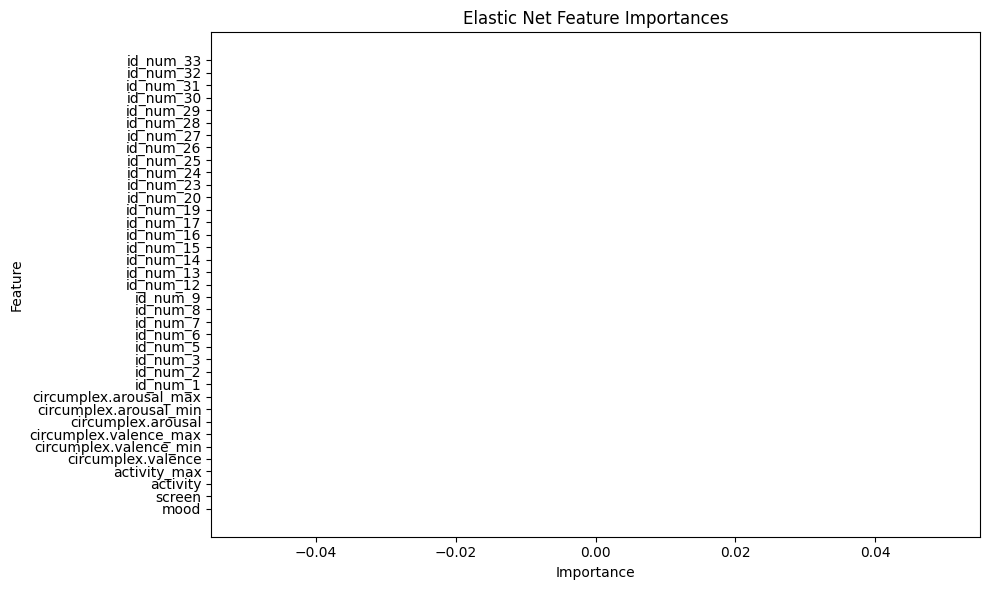

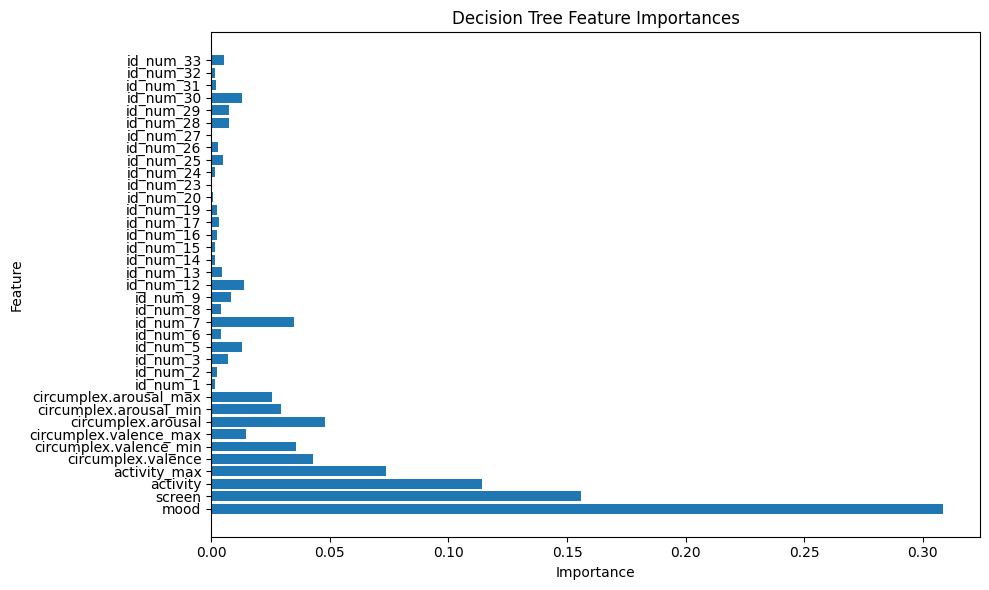

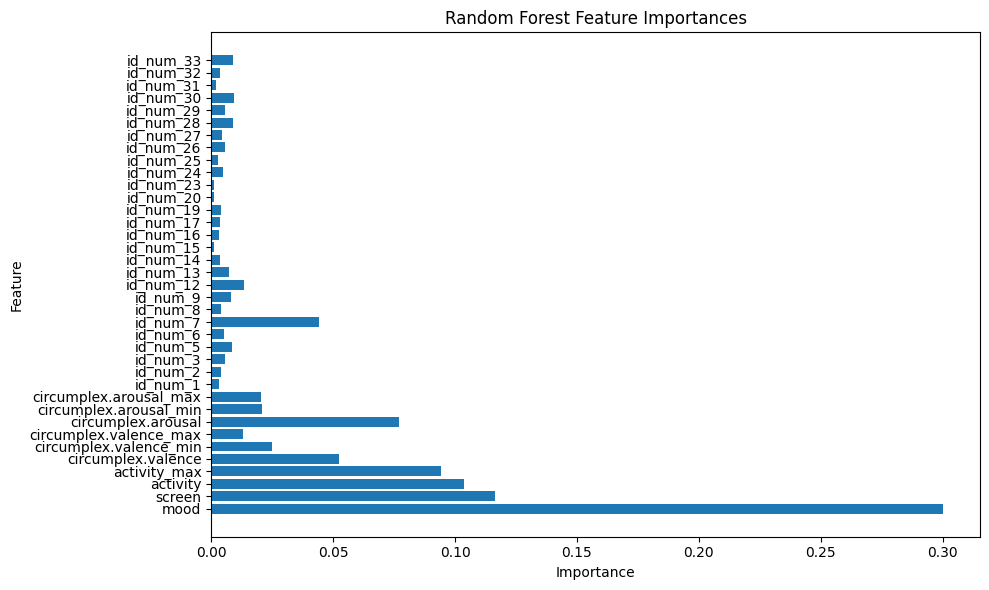

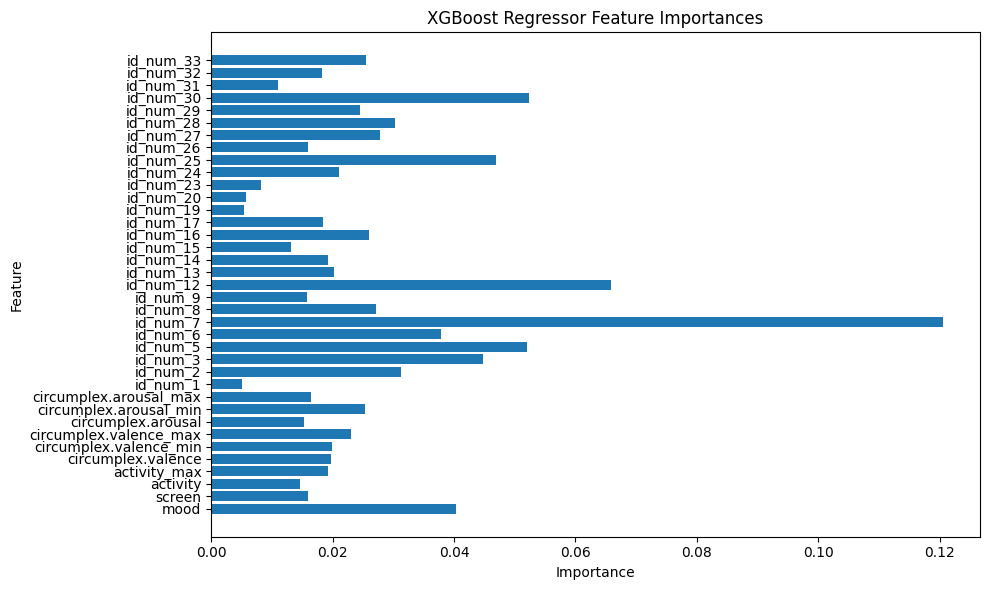

In [111]:
# feature importance 
importances = {}
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances[name] = model.coef_
    else:
        importances[name] = None
# plot feature importances
for name, importance in importances.items():
    if importance is not None:
        plt.figure(figsize=(10, 6))
        plt.barh(X.columns, importance)
        plt.title(f'{name} Feature Importances')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.tight_layout()
        # plt.savefig(f'tables/preprocessed/{name}_feature_importances.png')
        plt.show()
    else:
        print(f'{name} does not have feature importances.')


# save results to csv
if not os.path.exists('tables/results'):
    os.makedirs('tables/results')
    results_df.to_csv('tables/results/model_results.csv', index=True, header=True)
results_df.to_csv("tables/results/model_results.csv", mode='a', header=False, index=True)